# Phase Shift Approach - Velocity Measurements

Castelletti et al. searches for the correct slope of a surface by sweeping ranges/velocities and finding the correct phase correction by maximizing post-summed SNR. Here, we can employ a similar methodology but to find the correct spacecraft velocity.

- Surface echoes from Europa for ranging measurements will arrive later as the spacecraft moves away from the moon. 
- We can sum the received signals, each shifted with a phase correction $\Delta \phi$, to maximize post-summed SNR.
- We sweep ranging measurements to seek the correct velocities. 

This is advantageous because (i) velocity measurements can occur alongside ranging, without previous constraints from Doppler frequency; (ii) aliased results can be eliminated by comparing with Clipper's orbital properties in SPICE; and (iii) uncertainties in range and velocity can be found, across the parameter space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.ticker as mticker
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as path_effects
from scipy.signal import find_peaks
from scipy.ndimage import label, find_objects
import scienceplots

In [2]:
# REASON parameters
Pt = 10 # W
Gt = 10**(6/10) # 6 dB -> B
c = 2.998e8 # m/s
rcs = 2.5e10 # for HF, but we can assume for both

hf_wavelength = c/(9e6) # m
vhf_wavelength = c/(60e6) # m

# Set parameters
hf_pulse_length = 200e-6 # s
hf_repetition_freq = 3000 # Hz
hf_bandwidth = 1e6 # Hz
hf_s = hf_bandwidth/hf_pulse_length # chirp slope, Hz/s
hf_fc = 0 # Hz #9e6 is true value, assume 0 because the hardware downconverts to baseband

vhf_pulse_length = 236e-6 # s
vhf_repetition_freq = 3000 # Hz
vhf_bandwidth = 10e6 # Hz
vhf_s = vhf_bandwidth/vhf_pulse_length # chirp slope, Hz/s
vhf_fc = 60e6 # Hz

# sampling freqs
# 2x complex-valued baseband sampling rate
hf_fs = 2.4e6 
vhf_fs = 24e6

# noise power + effective area
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W
print("Galactic noise (power): {} W".format(N_power))

Galactic noise (power): 3.5153484038226244e-15 W


In [3]:
def radar_equation(Pt, Gt, d, rcs, wavelength):
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    return ((Pt*Gt)/(4*np.pi*d**2))*((rcs*Ae)/(4*np.pi*d**2)) # return power received

In [4]:
def chirp(s, tau, fs, fc, start, n, phase_shift):
    # s: slope
    # tau: pulse length
    # fs: sample rate
    # fc: center frequency
    # start: starting index of chirp
    # n: the length of the chirp including zero

    dt = 1 / fs
    npts = int(tau * fs)
    t = np.arange(-npts/2, npts/2) * dt
    phase = np.pi * s * t**2 + 2 * np.pi * fc * t + phase_shift
    chirp = np.zeros(n, dtype = np.complex_)
    chirp[start:len(phase)+start] = np.exp(1j * phase) # nonzero portion

    return chirp

In [5]:
from tqdm import tqdm

# Modelling ranging measurements for various ranges
def ranging_per_v(start_alt, end_time, vset):
    sampling_rate_m = vset/hf_repetition_freq # in meters
    range_array = np.arange(start_alt, start_alt + end_time*vset, sampling_rate_m)
    
    t = np.arange(0, end_time, 1/hf_fs) # time at the sampling frequency
    output_signal = np.zeros(len(t), dtype=np.complex_) # stores multiple pulses
    
    # ONE CHIRP
    print(int((1/hf_repetition_freq)*hf_fs))
    chirpsig = chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), 0)
    
    # iterate through chirps (using pulse_number) until total_pulses
    total_pulses = int(end_time / (1/hf_repetition_freq)) # total number of pulses
    pulse_number = 0
    while pulse_number < total_pulses:
        # if the chirp is cut off at the end of the time period
        if pulse_number * (1/hf_repetition_freq) > end_time:
            continue
        
        # signal spreads out 1/16 pi d^4
        Pr = radar_equation(Pt, Gt, range_array[pulse_number], rcs, hf_wavelength)
        
        start_index = math.ceil(pulse_number * (1/hf_repetition_freq) * hf_fs) # round up to pulse number
        
        # multiply by pulse indices for chirp function above
        output_signal[start_index:start_index+len(chirpsig)] = chirpsig*(np.sqrt(Pr)/np.sqrt(Pt)) 
        #decrease amplitude by ratio of sqrt(power received)/sqrt(power transmitted)
        # in units of AMPLITUDE
        
        pulse_number += 1 # go on to next pulse

    # keep first Pr so that we can convert to power later
    first_Pr = radar_equation(Pt, Gt, range_array[0], rcs, hf_wavelength)
    return output_signal, total_pulses, first_Pr 

## Single pulse SNR
For longest pulse, single pulse SNR with radar equation:

In [6]:
d = 40000*1e3 # m
Pr = radar_equation(Pt, Gt, d, rcs, hf_wavelength)
SNR_singlepulse = 10*np.log10(Pr/N_power)
print("SNR: {:.2f}".format(SNR_singlepulse))

SNR: -36.09


## Pulse Train

800
Pulse count: 800
Uncompressed P_r/N (power): -226.71 dB


/Users/michpark/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/michpark/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(66666.66666666667, 67000.0)

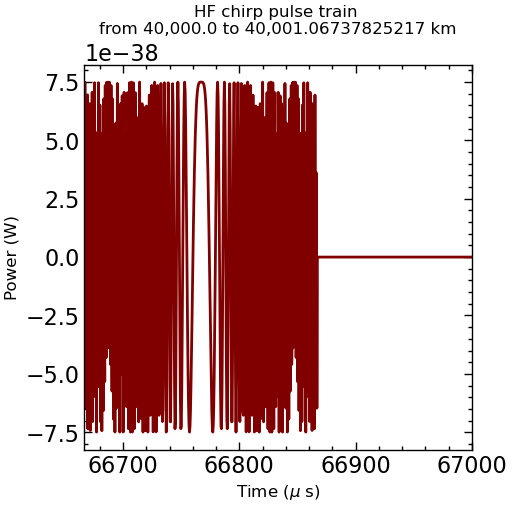

In [7]:
# set up range array
start_alt = d # m
end_time = 2*start_alt/c #s
vtrue = 4e3 #m/s
  
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, vtrue) # assume 4 km/s
noise_power = np.random.normal(loc=N_power, size=len(res)) # in units of amplitude (sqrt(W))

print("Pulse count: {}".format(pulse_count))

print("Uncompressed P_r/N (power): {:.2f} dB".format(10*np.log10(np.max(np.abs(Pr*res**2))/N_power)))

# Times for pulse train
times = np.linspace(0, end_time, len(res)) 
# final time = number of pulses * repetition freq

# Plot figure
plt.style.use(['science', 'notebook'])

fig, ax = plt.subplots(figsize=(5,5))
#plt.plot(times/(1e-6), Pr*res**2 + noise_power, c='gray', label='With noise')
plt.plot(times/(1e-6), Pr*res**2, c='maroon')
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vtrue)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (W)", fontsize = 12)
plt.xlim((200*(1/hf_repetition_freq) / 1e-6, 201*(1/hf_repetition_freq) / 1e-6))

### 3) Pulse compress + estimate the phase correction + SNR
For each surface echoes series, implement pulse compression. Use the maxima of each compressed pulse to estimate the slope of the straight line that travels through, which will be the phase correction. 
Find the final summed, phase-corrected pulse to gather the SNR (power received / noise). 


Hmmm... should i be finding or guessing the phase correction? wouldnt we always be maxing out the snr each time?

In [8]:
# input: res array with pulse train (chirps), estimated phase correction
# output: SNR
def get_SNR(res, noise, pulse_count, vtrue, vtest, dtrue):
    # matched filter is res (no noise), add noise to get the signal
    # matched filter == fft(signal)*fft(filter) conjugate
    if noise != 0: N = np.random.normal(loc=noise, size=len(res)) # create random Gaussian noise
    else: N = np.zeros(len(res), dtype=np.complex_) # else, no noise
    
    # apply matched filter to the noisy signal
    corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(res + N)*np.conj(np.fft.fft(res))))
    
    # find the peaks for each compressed pulse, separated by repetition frequency indexes
    peaks, _ = find_peaks(corr, distance=(1/hf_repetition_freq)*hf_fs)

    final_signal = np.zeros(int((1/hf_repetition_freq)*hf_fs), dtype=np.complex_)
    
    # create array of distance guesses based on pulse size
    time_halfwidth = ((1/hf_repetition_freq))/2
    distance_halfwidth = time_halfwidth*c # corresponds to which "dx" in range guesses
    dguesses = np.linspace(dtrue - distance_halfwidth, dtrue + distance_halfwidth, len(final_signal))
    # ARRAY OF RANGE GUESSES
    
    # FOR GUESSED VELOCITY 
    # Apply phase correction (for each pulse number), from dif between true + guess velocity
    vshift = vtest - vtrue 
    
    # ID the indices labelling the starts + ends of each pulse 
    starts = peaks-int((1/hf_repetition_freq)*hf_fs*0.5)
    ends = peaks+int((1/hf_repetition_freq)*hf_fs*0.5)
    
    phase_corrections = np.array([]) # stores phase corrections for each pulse number
    
    # Create a mask for valid indices -- removes if pulse is truncated
    valid_mask = (starts >= 0) & ((ends - starts) == len(final_signal)) & (ends <= len(corr))
    starts = starts[valid_mask] # apply filter to starts

    # Calculate phase shifts
    multiplier = np.arange(0, len(starts), 1)
    index_per_pulse = int((1/hf_repetition_freq)*hf_fs)

    # determines how many indices we should shift over
    t = (multiplier * (1/hf_fs))/(1/hf_repetition_freq) # fraction of time 
    phaseshift = ((((2*np.pi*np.abs(vshift)*t/hf_wavelength) % (2*np.pi)) / (2*np.pi))) * len(final_signal)
    phase_corrections = phaseshift.astype(int) # convert to ints

    # Extract the pulse data (filtered!)
    #all_indices = np.transpose(np.array([starts, ends]))
    all_pulses = np.array([],dtype=np.complex_)
    all_pulses = np.vstack([corr[start:start + len(final_signal)] for start in starts])

    ## PHASE SHIFTS!!! ##
    for i, shift in enumerate(phase_corrections):
        if vshift < 0: # moving further out from europa
            # pad with zeroes to the LEFT as we shift RIGHT 
            # place to the right
            final_signal[np.abs(shift):] += all_pulses[i][:len(final_signal)-np.abs(shift)]
        else: # moving closer to europa
            # move pulse back, pad with zeroes on right as we shift LEFT
            # place to the LEFT
            final_signal[0:len(all_pulses[i][shift:])] += all_pulses[i][shift:]
            
    # FINAL SUMMED PULSE

    #### PLOT THE PHASE SHIFTED PULSE?
    '''
    pulse_times = np.arange(0, (1/hf_repetition_freq), 1/hf_fs)
    norm = 3.234070710045566e-28
    if vtest == 4e3:
        plt.plot(pulse_times/(1e-6), np.real(final_signal)/norm, label='{:.2f}'.format((vtest-vtrue)), color='black', zorder=1)
    else:
        plt.plot(pulse_times/(1e-6), np.real(final_signal)/norm, label='{:.2f}'.format((vtest-vtrue)), alpha=0.8, zorder=10)
    
    plt.xlabel("Times (microseconds)")
    plt.ylabel("Normalized amplitude")

    #plt.title(r'Final Summed Pulse: $v_{{\rm{{guess}}}}$ = {0} km/s'.format(vtest/1e3), fontsize=12)
    #plt.title(r'Final Summed Pulse - Many Velocity Guesses', fontsize=12)
    plt.legend(title=r'$\Delta v$ (m/s)')
    plt.xlim((145, 190))
    '''
    
    # Instead of sweeping many amplitudes, we can just return the final signal
    # which represents dguess vs. amplitude 
    return dguesses, final_signal

Now get the SNR for our range guesses, though with a set guessed velocity.

800
Pulse count: 3000


/Users/michpark/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


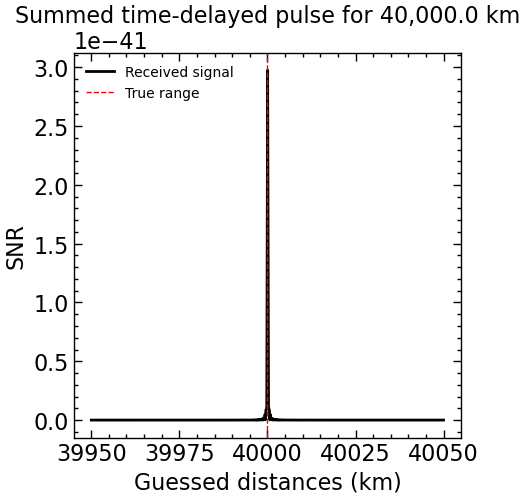

In [9]:
dtrue = 40000e3
vtrue = 4000
vguess = 4e3 # set true guess
end_time = 1 #s

res, pulse_count, Pr = ranging_per_v(start_alt, end_time, vtrue) # assume 4 km/s
print("Pulse count: " + str(pulse_count))

dguesses, sig = get_SNR(res*np.sqrt(Pr), 0, pulse_count, vtrue, vguess, dtrue)
# units of Sqrt(W) -- amplitude

'''
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), np.real(res), c='maroon')
plt.scatter(times[peaks]/(1e-6), np.zeros(len(peaks)), zorder=100)
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Amplitude", fontsize = 12)
'''

# plot signal along with range guesses
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(dguesses/1e3, np.abs(sig)**2/N_power, c='black', label='Received signal', alpha=1)
plt.xlabel(r"Guessed distances (km)")
plt.ylabel("SNR")
plt.title("Summed time-delayed pulse for {:,} km".format(dtrue/1e3))

plt.axvline(dtrue/1e3, color='red', lw=1, ls='--', label='True range')
ax.locator_params(axis='x', nbins=5)
#plt.ylim((0, 0.000025))
plt.legend(loc='upper left', fontsize = 10)

#### For one range, we get SNR per velocity:

In [10]:
SNR_array = np.array([])
plt.style.use(['science', 'notebook'])
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, 4e3) # assume 4 km/s

vcount = 0
vguesses = np.linspace(vtrue-.0005e3, vtrue+0.0005e3, 300)
for v in vguesses:
    if vcount % 100 == 0: print(vcount)
        
    _, shifted_signal  = get_SNR(res*np.sqrt(Pr), N_power, pulse_count, 4e3, v, 40000e3) # true alt=40000
    SNR = 10*np.log10(np.max((np.abs(shifted_signal)**2)/N_power)) # in units of power
    SNR_array = np.append(SNR_array, SNR)
    vcount += 1

800
0
100
200


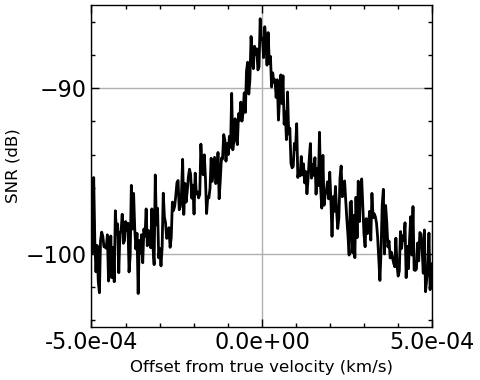

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.plot((vguesses - np.full(len(vguesses), vtrue)) / 1000, SNR_array, color='black', lw=2)
plt.xlabel("Offset from true velocity (km/s)", fontsize=12)
plt.ylabel("SNR (dB)", fontsize=12)
plt.ylim(bottom = np.min(SNR_array)-2)
plt.xlim(((vguesses[0]-vtrue)/1000, (vguesses[-1]-vtrue)/1000))

ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='y', nbins=3)
ax.grid('on')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.tight_layout()

### 4) Nested for loop -- many ranges + many velocities
Create a nested for loop implementing each above. Gather the true + recovered ranges, true + recovered velocities (convert phase correction -> velocity), SNR in a 5-value array. 

In [63]:
def guess_both(dtrue, vtrue, vguess_offset, vguess_res):
    velocity_guesses = np.linspace(vtrue-vguess_offset, vtrue+vguess_offset, vguess_res) # m/s
    end_time = 2*dtrue/c  # s

    final = np.zeros((800, len(velocity_guesses))) # 1200 hardcoded ig

    sampling_rate_m = vtrue/hf_repetition_freq
    res, pulse_count, Pr = ranging_per_v(dtrue, end_time, vtrue) # with true values
    print("Pulse count: " + str(pulse_count))

    for idv, v in enumerate(tqdm(velocity_guesses)):
        #noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
        distance_guesses, snr_guesses = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, vtrue, v, dtrue)
        SNR = 10*np.log10((np.abs(snr_guesses)**2)/N_power + (10**-100))
        final[:,idv] = SNR
    
    return final

In [64]:
final = guess_both(400000e3, 100000e3, 0.0005e3, 50)
# dtrue = 400000e3, vtrue = 100000e3 
#np.savetxt("final/final_400000km.txt", final)

800
Pulse count: 8005


100%|███████████████████████████████████████████| 50/50 [03:57<00:00,  4.75s/it]


Determine the rectangle that fits the top 0.1% of SNR and the resolution/accuracy of range/velocity:

In [71]:
def get_rectangle(final):
    # DRAW CONTOUR
    threshold = np.percentile(final, 99.9)  # Top 0.1% as the brightest
    brightest_region = final >= threshold
    labeled_array, num_features = label(brightest_region)
    regions = find_objects(labeled_array)
    largest_region = max(regions, key=lambda r: (r[0].stop - r[0].start) * (r[1].stop - r[1].start))

    # Get the coordinates for the rectangle
    y_start, y_stop = (distance_guesses[max(0, largest_region[0].start)] - dtrue), (distance_guesses[min(final.shape[0]-1, largest_region[0].stop)] - dtrue)
    x_start, x_stop = (velocity_guesses[max(0, largest_region[1].start)] - vtrue), (velocity_guesses[min(final.shape[1]-1, largest_region[1].stop)] - vtrue)

    return [x_start, x_stop, y_start, y_stop]
    # returns rectangle with top 0.1% SNR (x, y)
    
def get_resolution(final, rect_coords):
    [x_start, x_stop, y_start, y_stop] = rect_coords
    # label with the width + height 
    # resolution = width of the top 0.1% box
    # accuracy = how off from actual true value
    range_res = (y_stop-y_start)/1e3
    vel_res = x_stop-x_start
    range_acc = np.mean([y_start, y_stop])/1e3
    vel_acc = np.mean([x_stop,x_start])
    
    return range_res, vel_res, range_acc, vel_acc

Plot results (heatmap).

Recovered range: 399999.937463 km
Recovered velocity: 100000.000010 km/s
--------------
Range resolution: 8.755111e-01 km
Velocity resolution: 8.163266e-02 m/s
--------------
Range accuracy: 0.000000e+00 km
Velocity accuracy: 1.020408e-02 m/s
Range resolution: 8.755111e-01 km
Velocity resolution: 8.163266e-02 m/s
--------------
Range accuracy: 0.000000e+00 km
Velocity accuracy: 1.020408e-02 m/s


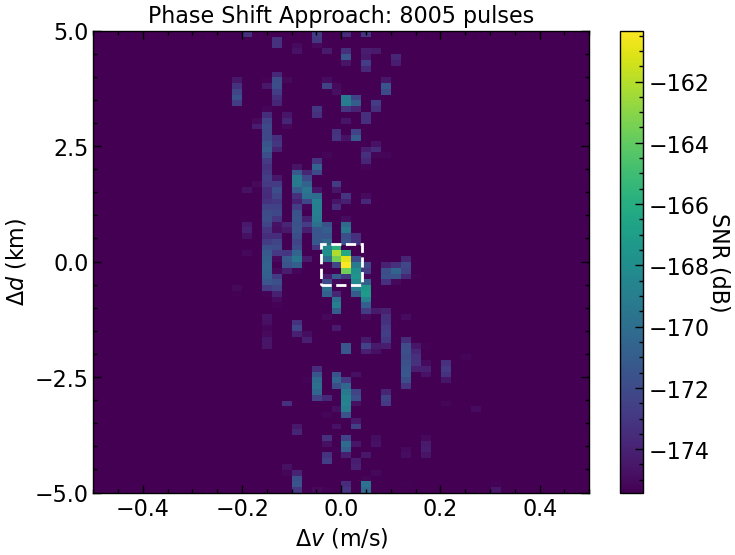

In [73]:
#plt.style.use('/Users/michpark/Sync/Documents/JPL-EUROPA/sample.mplstyle')

# create the colorplot
fig, ax = plt.subplots(figsize=(8, 6))
vmin_val = (np.max(final)-np.min(final)) / 1.3 + np.min(final)

heatmap = ax.imshow(final, cmap='viridis', origin="lower",aspect='auto', vmin =vmin_val, 
              vmax = np.max(final), extent =[(np.min(velocity_guesses)-vtrue), 
                                     (np.max(velocity_guesses)-vtrue), (np.min(distance_guesses)-dtrue)/1e3, 
                                     (np.max(distance_guesses)-dtrue)/1e3])

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('SNR (dB)', rotation=270, labelpad=15)

# Customize the plot
ax.set_ylabel(r'$\Delta d$ (km)')
ax.set_xlabel(r'$\Delta v$ (m/s)')
ax.set_title('Phase Shift Approach: {} pulses'.format(pulse_count, dtrue))

recovered_indices = np.unravel_index(final.argmax(), final.shape)
print("Recovered range: {:.6f} km".format(distance_guesses[recovered_indices[0]]/1e3))
print("Recovered velocity: {:.6f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))
print("--------------")

ax.locator_params(axis='x', nbins=5)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1.1e'))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%1.1e'))
ax.locator_params(axis='y', nbins=5)

# Obtain top 0.1% SNR rectangle parameters
[x_start, x_stop, y_start, y_stop] = get_rectangle(final)

# Display resolution params
range_res, vel_res, range_acc, vel_acc = get_resolution(final, [x_start, x_stop, y_start, y_stop])
print("Range resolution: {:e} km".format(range_res))
print("Velocity resolution: {:e} m/s".format(vel_res))
print("--------------")
print("Range accuracy: {:e} km".format(range_acc))
print("Velocity accuracy: {:e} m/s".format(vel_acc))


# Draw the rectangle
rect = plt.Rectangle((x_start - 0.5*np.diff(velocity_guesses)[0], y_start/1e3 - 0.5*np.diff(distance_guesses)[0]/1e3), (x_stop - x_start), (y_stop - y_start)/1e3, 
                     edgecolor='white', facecolor='none', linewidth=2, ls='--', path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
ax.add_patch(rect)

# annotate with the width + height of box
#ax.annotate('{:.3f} cm/s'.format(vel_res), (x_start + (x_stop-x_start)/2, y_start-(y_stop-y_start)/2.9), ha='center', color='white', fontsize=14, fontweight='bold')
#ax.annotate('{:.3f} km'.format(range_res), (x_start - (x_stop-x_start)/1.3, y_start + (y_stop-y_start)/2), va='center', color='white', fontsize=14, fontweight='bold')

# annotate with recovered values
#ax.text(x=0.05, y=0.93, s=r'Range offset: {:.4f} km'.format(np.mean([y_start, y_stop])/1e3), transform=ax.transAxes, color='white')
#ax.text(x=0.05, y=0.89, s=r'Velocity offset: {:.4f} m/s'.format(np.mean([x_start, x_stop])), transform=ax.transAxes, color='white')

#plt.xlim((-0.2, 0.2))
plt.ylim((x_start/1e3-5, x_stop/1e3+5))

plt.show()

## Range/velocity resolution vs. range!
To explore how resolution changes as we go further and closer to Europa -- might be good to include in the paper to demonstrate tradeoff.

In [93]:
true_range = np.linspace(40000e3, 100000e3, 10) # from 40,000 km to 100,000 km

# resolution = width of the top 0.1% box
# accuracy = how off from actual true value

res_array = np.zeros(4)

for dtrue in true_range:
    print("TRUE RANGE: {} km".format(dtrue/1000))
    # Run colormap determination
    final = guess_both(dtrue, 100000e3, 0.0005e3, 50)
    
    # get top 0.1% SNR -> resolution params
    [x_start, x_stop, y_start, y_stop] = get_rectangle(final)
    all_res = get_resolution(final, [x_start, x_stop, y_start, y_stop])
    
    res_array = np.vstack((res_array, all_res))

res_array = res_array[1:] # remove first row of zeroes
# range_res, vel_res, range_acc, vel_acc

TRUE RANGE: 40000.0 km
800
Pulse count: 800


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.11it/s]


Range resolution: 3.752190e-01 km
Velocity resolution: 2.857143e-01 m/s
--------------
Range accuracy: 3.600001e+05 km
Velocity accuracy: 1.020408e-02 m/s
TRUE RANGE: 46666.666666666664 km
800
Pulse count: 933


100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.69it/s]


Range resolution: 6.253650e-01 km
Velocity resolution: 3.469388e-01 m/s
--------------
Range accuracy: 3.533335e+05 km
Velocity accuracy: 0.000000e+00 m/s
TRUE RANGE: 53333.333333333336 km
800
Pulse count: 1067


100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


Range resolution: 7.504380e-01 km
Velocity resolution: 3.061225e-01 m/s
--------------
Range accuracy: 3.466669e+05 km
Velocity accuracy: -2.040817e-02 m/s
TRUE RANGE: 60000.0 km
800
Pulse count: 1200


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.78it/s]


Range resolution: 7.504380e-01 km
Velocity resolution: 2.857143e-01 m/s
--------------
Range accuracy: 3.400001e+05 km
Velocity accuracy: 3.061225e-02 m/s
TRUE RANGE: 66666.66666666667 km
800
Pulse count: 1334


100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


Range resolution: 6.253650e-01 km
Velocity resolution: 2.653061e-01 m/s
--------------
Range accuracy: 3.333335e+05 km
Velocity accuracy: 0.000000e+00 m/s
TRUE RANGE: 73333.33333333334 km
800
Pulse count: 1467


100%|███████████████████████████████████████████| 50/50 [00:21<00:00,  2.30it/s]


Range resolution: 6.253650e-01 km
Velocity resolution: 2.448980e-01 m/s
--------------
Range accuracy: 3.266668e+05 km
Velocity accuracy: 1.020408e-02 m/s
TRUE RANGE: 80000.0 km
800
Pulse count: 1601


100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


Range resolution: 7.504380e-01 km
Velocity resolution: 2.244898e-01 m/s
--------------
Range accuracy: 3.200002e+05 km
Velocity accuracy: 0.000000e+00 m/s
TRUE RANGE: 86666.66666666667 km
800
Pulse count: 1734


100%|███████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


Range resolution: 8.755111e-01 km
Velocity resolution: 2.040816e-01 m/s
--------------
Range accuracy: 3.133336e+05 km
Velocity accuracy: 1.020408e-02 m/s
TRUE RANGE: 93333.33333333334 km
800
Pulse count: 1867


100%|███████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


Range resolution: 7.504380e-01 km
Velocity resolution: 2.040816e-01 m/s
--------------
Range accuracy: 3.066667e+05 km
Velocity accuracy: 1.020408e-02 m/s
TRUE RANGE: 100000.0 km
800
Pulse count: 2001


100%|███████████████████████████████████████████| 50/50 [00:37<00:00,  1.35it/s]

Range resolution: 7.504380e-01 km
Velocity resolution: 1.836735e-01 m/s
--------------
Range accuracy: 3.000001e+05 km
Velocity accuracy: 2.040817e-02 m/s


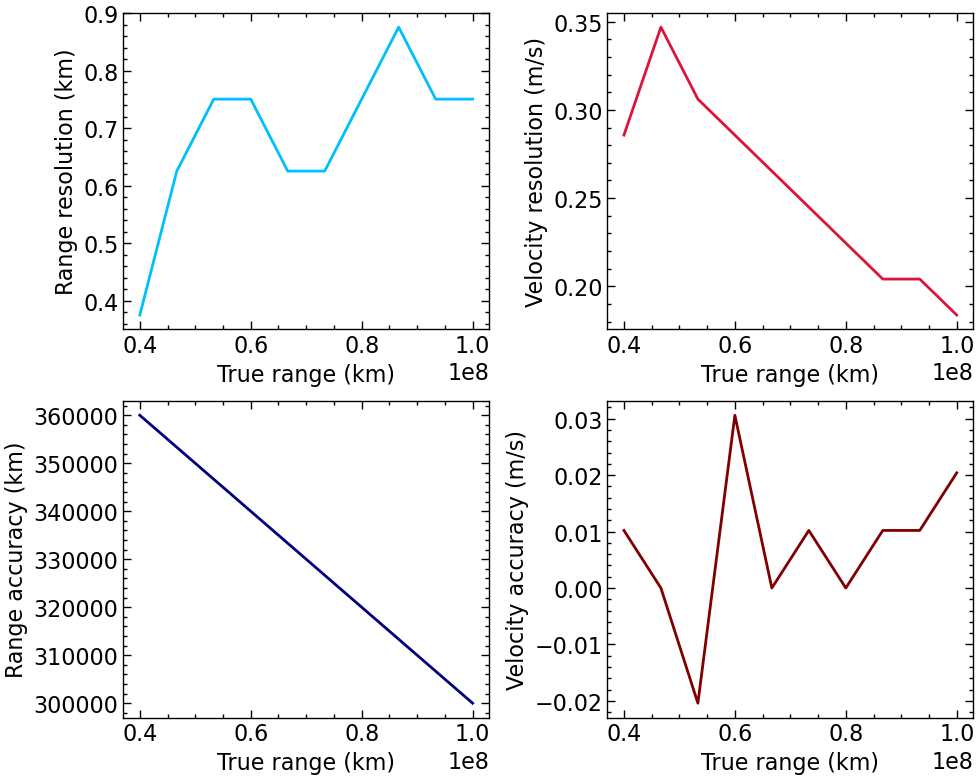

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

# PLOT RESULTS (range/vel acc/res)
ax[0,0].plot(true_range, res_array[:,0], c='deepskyblue')
ax[0,1].plot(true_range, res_array[:,1], c='crimson')
ax[1,0].plot(true_range, res_array[:,2], c='navy')
ax[1,1].plot(true_range, res_array[:,3], c='maroon')

# PRETTIFY THE AXES
ax[0, 0].set_ylabel("Range resolution (km)")
ax[0, 1].set_ylabel("Velocity resolution (m/s)")
ax[1, 0].set_ylabel("Range accuracy (km)")
ax[1, 1].set_ylabel("Velocity accuracy (m/s)")

for axes in ax.reshape(-1):
    #axes.locator_params(axis='x', nbins=7)
    #axes.locator_params(axis='y', nbins=5)
    axes.set_xlabel("True range (km)")
    
plt.tight_layout()

### Paper plot: 80 vs 800 pulses, with without noise

In [ ]:
all_final = [final_part, final_full]

plt.style.use(['science', 'notebook'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for j in range(2):
    ax = axs[j]
    final = all_final[j]
    vmin_val = (np.max(final)-np.min(final)) / 1.2 + np.min(final)
    heatmap = ax.imshow(final, cmap='viridis', origin="lower",aspect='auto', vmin = vmin_val, 
              vmax = np.max(final), extent =[(np.min(velocity_guesses)-vtrue), 
                                     (np.max(velocity_guesses)-vtrue), (np.min(distance_guesses)-dtrue)/1e3, 
                                     (np.max(distance_guesses)-dtrue)/1e3])

    # Customize the plot
    ax.set_ylabel(r'$\Delta d$ (km)')
    ax.set_xlabel(r'$\Delta v$ (m/s)')
    
    ax.locator_params(axis='x', nbins=5)
    recovered_indices = np.unravel_index(final.argmax(), final.shape)

    # DRAW CONTOUR
    threshold = np.percentile(final, 99)  # Top 1% as the brightest
    brightest_region = final >= threshold
    labeled_array, num_features = label(brightest_region)
    regions = find_objects(labeled_array)
    largest_region = max(regions, key=lambda r: (r[0].stop - r[0].start) * (r[1].stop - r[1].start))

    y_start, y_stop = (distance_guesses[max(0, largest_region[0].start)] - dtrue)/1e3, (distance_guesses[min(final.shape[0], largest_region[0].stop)] - dtrue)/1e3
    x_start, x_stop = (velocity_guesses[max(0, largest_region[1].start)] - vtrue), (velocity_guesses[min(final.shape[1], largest_region[1].stop)] - vtrue)

    # Draw the rectangle
    rect = plt.Rectangle((x_start - 0.5*np.diff(velocity_guesses)[0], y_start - 0.5*np.diff(distance_guesses)[0]/1e3), x_stop - x_start, y_stop - y_start, 
                         edgecolor='white', facecolor='none', linewidth=2, ls='--', path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
    ax.add_patch(rect)
    ax.set_xlim((-0.5, 0.5))
    ax.set_ylim((-1, 1))

axs[0].set_title("400 pulses")
axs[1].set_title("800 pulses")
plt.tight_layout()
# Add colorbar
bottom, top = 0.1, 0.9
left, right = 0.1, 0.8
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.1, wspace=0.25)
cbar_ax = fig.add_axes([0.83, bottom, 0.02, top-bottom])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
cbar.set_label('SNR (dB)', rotation=270, labelpad=20)

#ax.text(x=0.05, y=0.93, s=r'Recovered range: {:.6f} km'.format(distance_guesses[recovered_indices[0]]/1e3), transform=ax.transAxes, color='white')
#ax.text(x=0.05, y=0.89, s=r'Recovered velocity: {:.6f} km/s'.format(velocity_guesses[recovered_indices[1]]/1e3), transform=ax.transAxes, color='white')
plt.show()

### 5) Plot true vs. recovered range + true vs. recovered velocity 
Create true vs. recovered plots, colorcoded by SNR first to visualize general patterns. 

In [ ]:
'''
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
dmaxidx = np.argwhere(final_less==np.amax(final_less, axis=0, keepdims=True))
recovered_ranges = distance_guesses[dmaxidx[:,0]]/1e3

vmaxidx = np.argwhere(final_less==np.amax(final_less, axis=1, keepdims=True))
recovered_velocities = velocity_guesses[vmaxidx[:,1]]/1e3

binsd = np.linspace(np.min(recovered_ranges), np.max(recovered_ranges), 8)
binsv = np.linspace(np.min(recovered_velocities), np.max(recovered_velocities), 8)
ax[0].hist(recovered_ranges, color='#107394', bins=binsd)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
ax[1].hist(recovered_velocities, color='#7b0829', bins=binsv)
ax[1].axvline(vtrue/1e3, ls='--', color='black')

ax[0].set_xlabel("Recovered ranges (km)", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
ax[1].set_xlabel("Recovered velocities (km/s)", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
ax[0].set_xlim(np.min(distance_guesses)/1e3 - 5, np.max(distance_guesses)/1e3 + 5)
ax[1].set_xlim(np.min(velocity_guesses)/1e3 - 0.1, np.max(velocity_guesses)/1e3 + 0.1)


# CALCULATE BIAS AND SCATTER
print(recovered_ranges)
range_bias = np.median(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3)))
velocity_bias = np.median(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3))
velocity_scatter = np.std(np.abs(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3)))                    
                       
ax[0].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394')
ax[0].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394')
ax[1].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829')
ax[1].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829')
         
plt.tight_layout()
'''

### 6) Monte Carlo type plot 
(1) Find the brightest SNR point on heatmap -> (2) Rerun new heatmap and get its brightest SNR point -> (3) repeat.
We can see how the brightest SNR point deviates for multiple runs of the heatmap (standard deviation of the movement) to see extent of noise's influence

In [84]:
# set up params
dtrue = 1000000e3
vtrue = 100000e3 # m/s -- the actual velocity

hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W

n_iterations = 101

pbar = tqdm(total=n_iterations)

all_ranges = np.zeros(n_iterations)
all_velocities = np.zeros(n_iterations)

n = 1
velocity_guesses = np.linspace(vtrue-0.0005e3, vtrue+0.0005e3, 50) # m/s
end_time = 2*dtrue/c # s

res, pulse_count, Pr = ranging_per_v(dtrue, end_time, vtrue) # with true values

while n <= n_iterations:
    # Preallocate results
    max_SNR = -np.inf  # Initialize maximum SNR to a very low value
    best_range = None
    best_velocity = None

    for idv, v in enumerate(velocity_guesses):
        distance_guesses, snr_guesses = get_SNR(res*np.sqrt(Pr), np.sqrt(N_power), pulse_count, vtrue, v, dtrue)
        SNR = 10*np.log10((np.abs(snr_guesses)**2)/N_power + (10**-100))
        
        current_SNR = np.max(SNR) # find the maximum among the distance guesses

        if current_SNR > max_SNR:
            max_SNR = current_SNR
            best_range = distance_guesses[np.argmax(SNR)] / 1e3  # Store the best range in km
            best_velocity = velocity_guesses[idv]  # Store the best velocity in m/s

    all_ranges[n-1] = best_range
    all_velocities[n-1] = best_velocity
    
    # iterate and update progress bar
    n += 1
    pbar.update(1)
    
pbar.close()


  0%|                                                   | 0/101 [01:21<?, ?it/s]


800


KeyboardInterrupt: 

In [ ]:
np.savetxt("iterative_heatmaps/allranges-millionkm.txt", all_ranges)
np.savetxt("iterative_heatmaps/allvelocities-millionkm.txt", all_velocities)

In [ ]:
import math
import scipy.stats as stats

all_ranges = np.loadtxt("iterative_heatmaps/allranges-full.txt")
all_velocities = np.loadtxt("iterative_heatmaps/allvelocities-full.txt")

print(all_velocities-vtrue)
n = len(all_ranges)

print(pulse_count)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
N_bins = math.ceil(np.sqrt(n)) # general policy -- number of bins = round up sqrt(number of data)

# BUILD THE HISTOGRAMS
binsd = np.linspace(-1, 1, int(N_bins/1.5))
binsv = np.linspace(-0.5, 0.5, int(N_bins))
_, xrange, _ = ax[0].hist(all_ranges-dtrue/1e3, color='#107394', bins=binsd, edgecolor='black', linewidth=1.2)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
_, xvel, _ = ax[1].hist(all_velocities-vtrue, color='#7b0829', bins=binsv, edgecolor='black', linewidth=1.2)
ax[1].axvline(vtrue, ls='--', color='black')

# PRETTIFY THE AXES
ax[0].set_xlabel(r'$\Delta d$ (km)')
ax[1].set_xlabel(r'$\Delta v$ (m/s)')
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)
ax[0].locator_params(axis='x', nbins=5)
ax[1].locator_params(axis='x', nbins=5)

# CALCULATE BIAS AND SCATTER
range_bias = np.median(all_ranges - np.full(len(all_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(all_ranges - np.full(len(all_ranges), dtrue/1e3)))
velocity_bias = np.median(all_velocities - np.full(len(all_velocities), vtrue))
velocity_scatter = np.std(np.abs(all_velocities - np.full(len(all_velocities), vtrue)))                    
                       
ax[0].text(x=0.05, y=0.91, s=r'$\mu$ = {:.3f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394', fontsize=13)
ax[0].text(x=0.05, y=0.85, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394', fontsize=13)
ax[1].text(x=0.53, y=0.91, s=r'$\mu$ = {:.2e} m/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829', fontsize=13)
ax[1].text(x=0.53, y=0.85, s=r'$\sigma$ = {:.2e}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829', fontsize=13)
         
for axes in ax.reshape(-1):
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].set_ylim(top=400)

fig.suptitle("800 pulses", fontsize=16)
plt.tight_layout()


### SNR vs. resolution plots

NameError: name 'n' is not defined

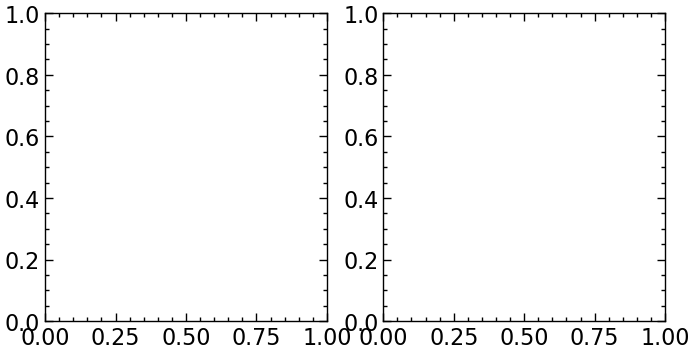

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
N_bins = math.ceil(np.sqrt(n)) # general policy -- number of bins = round up sqrt(number of data)

ax[0].scatter(snr, all_rangeres)
ax[1].scatter(snr, all_velres)

# PRETTIFY THE AXES
ax[0].set_ylabel("Range resolution (km)")
ax[1].set_ylabel("Velocity resolution (cm/s)")
fig.suptitle("SNR vs. resolution for {} pulses".format(pulse_count))

for axes in ax.reshape(-1):
    axes.locator_params(axis='x', nbins=7)
    axes.locator_params(axis='y', nbins=5)
    axes.set_xlabel("SNR (dB)")
    
plt.tight_layout()